# Neoclassical transport for an axisymmetric plasma

Currently a work in progress.

# Houlberg_1997

Equation 6:

$$F_\alpha^{ai} = \int m_a v L_{\alpha-1}^{3/2}(x_a^2)C_{ai} dv$$


$$<F_\alpha^{ai} \cdot B> = \sum_{b,j,\beta} l_{\alpha \beta}^{ai, bj} \hat{u}_\beta^{bj}$$


$$l_{\alpha \beta} ^{ai, bj} = \xi_{ai}(\delta_{ai,bj} M_{\alpha\beta}^a + \xi_{bj} N_{\alpha \beta}^{ab})$$

$$\xi_{ai} = n_{ai} Z_i^2 / \sum_i n_{ai} Z_i^2$$

$$\mu_{\alpha \beta}^{ai} = \frac{8}{3 \sqrt\pi} n_{ai} m_a (-1)^{\alpha + \beta} \times \int_0^\infty dx x^4 e^{-x^2} L_{\alpha-1}^{3/2} L_{\beta-1}^{3/2} \bar{K}^{ai}$$

$$\bar{K}^{ai} = K_B K_{PS} / (K_B + K_{PS})$$
(upuściłem superskrypt ai wszędzie);
$K_B, K_{PS}$ zdefiniowane w appendix B

Equation 23:

$$\sum_\beta (\xi_{ai} M^a_{\alpha \beta} - \hat{\mu}^{ai}_{\alpha\beta}) \hat{\mu}_\beta^{ai} - (\beta_{cx,a} + \beta_{an,\alpha}) \hat{u}_\alpha^{ai} 
= 
- \xi_{ai} =\sum_\beta \sum_b N^{ab}_{\alpha \beta} \bar{\mu}_\beta^b + \sum_\beta \hat{\mu}_{\alpha\beta}^{ai}S_{\theta,\beta}^{ai} - S_{E_\parallel,\alpha}^{ai} - S_{NBI\parallel, \alpha}^{ai}$$

$$\bar{\mu}_\beta^b = \sum_j \xi_{bj} \hat{\mu}_\beta^{bj}$$

Eventually we can go back to $$D^{C,\alpha} = \frac{- \Gamma^{C,\alpha}}{n_c \nabla(\ln \alpha)}$$

for $\alpha \in \{ T_e, T_i, n_e, n_D, n_C \}$

Eq. 41a:

$$\Gamma_{BP}^{ai} = -\hat{F} e_{ai}^{-1} \sum_\beta \hat{\mu}_{1\beta}^{ai} \hat{u}_{\theta,\beta}^{ai}$$

And the other gammas... around eq. 43

TODO assume we can skip heat flows for now. That's 41b

In [1]:
from plasmapy.particles import IonizationStateCollection

all_species = IonizationStateCollection(
    {
        "H": [0, 1],
        #      "D": [0, 1],   raises ParticleError, why?
        "C": [0, 0, 0, 0, 0, 0, 1],
    },
    n0=1e20 * u.m ** -3,
    abundances={"H": 1, "C": 0.08},
    T_e=10 * u.eV,
)
all_species["H"].n_e

<Quantity 1.e+20 1 / m3>

In [2]:
h1 = all_species["H"][1]
h1.number_density, h1.T_i

(<Quantity 1.e+20 1 / m3>, <Quantity 116045.1812155 K>)

# Flux surface

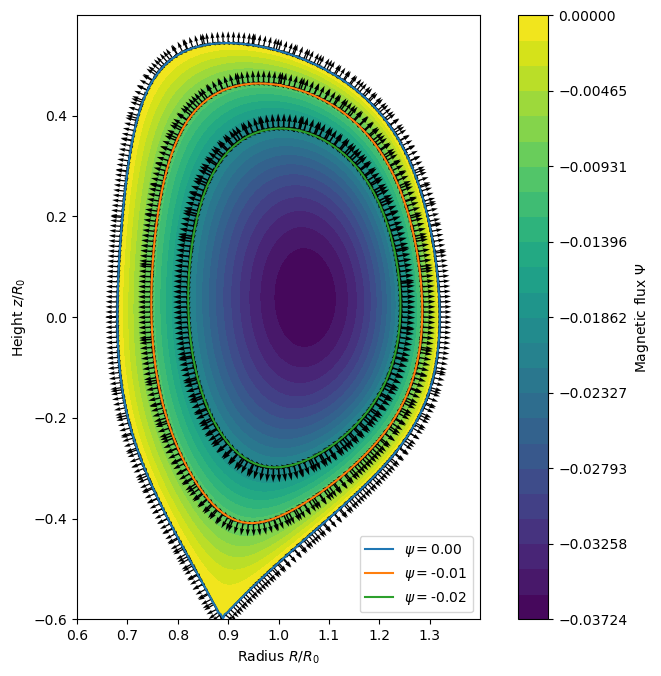

In [3]:
import plasmaboundaries

from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = plasmaboundaries.ITER.copy()
assert params["triangularity"] <= 0.841  # for convex plasma surfaces
eq = SymbolicEquilibrium(**params, B0=5.2, config="single-null")
ax = eq.plot((0.6, 1.4, 0.001), (-0.6, 0.6, 0.001), vmax=-0)
for psi_value in [0, -0.01, -0.02]:
    fs = eq.get_flux_surface(psi_value)
    fs.plot(ax, B=True, n=True)

## On a grid

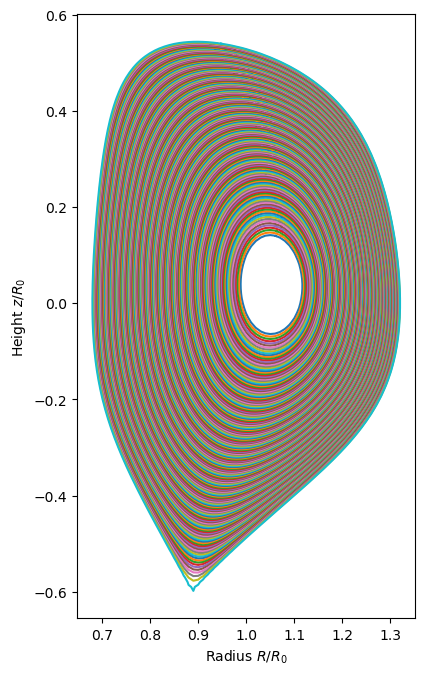

In [4]:
levels = np.linspace(-0.03556, 0, 200)
surfaces = {level: eq.get_flux_surface(level) for level in levels}

# ax = eq.plot()
ax = None
for fs in surfaces.values():
    ax = fs.plot(ax, legend=False)

## One particular surface

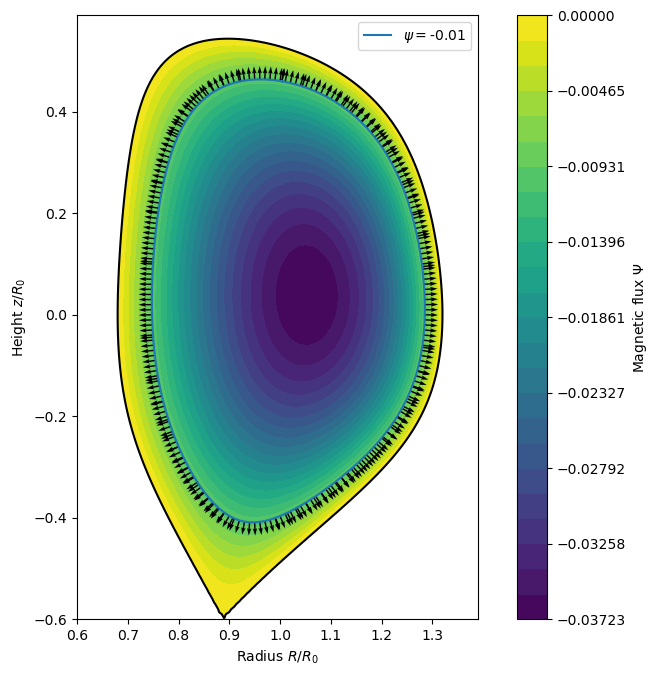

In [5]:
ax = eq.plot()
fs = eq.get_flux_surface(-0.01)
fs.plot(ax, n=True);

In [6]:
fs.trapped_fraction()

0.5179670516625869

# Steady state force balance model

## TODO Viscosity coefficients

eq. 15

In [7]:
a = all_species["H"]
ai = a[1]

IonicLevel('H 1+', ionic_fraction=1.0)

### ????

In [8]:
from plasmapy.formulary.neoclassical import K_B_ai

In [9]:
K_B_ai(1, 1, a, all_species, fs)

<Quantity 10340684.63637584 1 / s>

In [10]:
x = np.logspace(-1, 3, 1000)
y = K_B_ai(x, 1, a, all_species, fs)

<Quantity [2.44655590e+09, 2.40091327e+09, 2.35610541e+09, 2.31211711e+09,
           2.26893338e+09, 2.22653957e+09, 2.18492124e+09, 2.14406424e+09,
           2.10395469e+09, 2.06457895e+09, 2.02592361e+09, 1.98797555e+09,
           1.95072185e+09, 1.91414985e+09, 1.87824711e+09, 1.84300142e+09,
           1.80840079e+09, 1.77443347e+09, 1.74108789e+09, 1.70835272e+09,
           1.67621683e+09, 1.64466928e+09, 1.61369936e+09, 1.58329652e+09,
           1.55345042e+09, 1.52415092e+09, 1.49538806e+09, 1.46715204e+09,
           1.43943327e+09, 1.41222232e+09, 1.38550993e+09, 1.35928702e+09,
           1.33354466e+09, 1.30827411e+09, 1.28346677e+09, 1.25911420e+09,
           1.23520812e+09, 1.21174038e+09, 1.18870302e+09, 1.16608820e+09,
           1.14388821e+09, 1.12209551e+09, 1.10070268e+09, 1.07970246e+09,
           1.05908768e+09, 1.03885134e+09, 1.01898655e+09, 9.99486546e+08,
           9.80344704e+08, 9.61554504e+08, 9.43109552e+08, 9.25003570e+08,
           9.07230396e+08

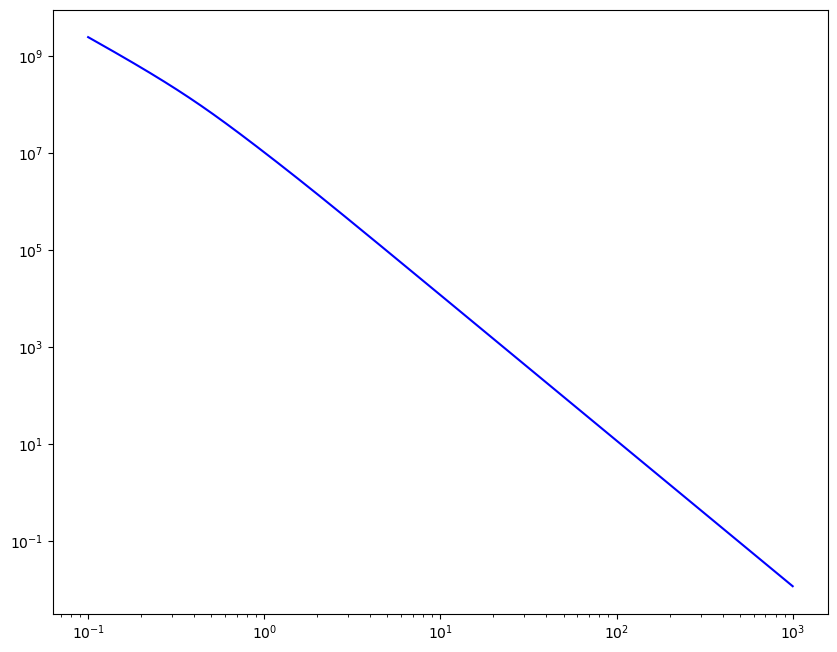

In [11]:
plt.loglog(x, y, "b-")

In [12]:
from scipy import integrate

In [13]:
from plasmapy.formulary.neoclassical import K, LaguerrePolynomials, mu_hat

mu_hat(ai)

<Quantity [[ 1.67291244e-07, -2.18306802e-24,  1.39716353e-23],
           [-2.18306802e-24,  4.18228110e-07, -0.00000000e+00],
           [ 1.39716353e-23, -0.00000000e+00,  7.31899193e-07]] kg / (m3 s)>

# Reduced charge state solution

> When Eq. ~1! is expressed in terms of the parallel flows
using Eq. ~19! to eliminate the poloidal flows# and the sums
over the charge states j for species b are carried out, we
obtain a set of three equations ( a = 1,2,3) for each charge
state of each isotope,

$$\sum_\beta (\xi_{ai} M^a_{\alpha \beta} - \hat{\mu}^{ai}_{\alpha\beta}) \hat{\mu}_\beta^{ai} - (\beta_{cx,a} + \beta_{an,\alpha}) \hat{u}_\alpha^{ai} 
= 
- \xi_{ai} =\sum_\beta \sum_b N^{ab}_{\alpha \beta} \bar{\mu}_\beta^b + \sum_\beta \hat{\mu}_{\alpha\beta}^{ai}S_{\theta,\beta}^{ai} - S_{E_\parallel,\alpha}^{ai} - S_{NBI\parallel, \alpha}^{ai}$$

$$\bar{\mu}_\beta^b = \sum_j \xi_{bj} \hat{\mu}_\beta^{bj}$$

So we take the general equation (25)

$$A^{ai} \cdot \hat{u}^{ai} = \xi_{ai} \Lambda^a (\bar{u}^b) + S^{ai}$$

This means every charge level has

- [x] an $A^{ai}$ 3x3 matrix (28) using
    - [x] script M
    - [x] viscosities $\hat{\mu}_{\alpha\beta}^{ai}$
    - [x] the charge weight $\xi_{ai}$
    - [x] beta coefficients
- [ ] the $\Lambda^a$ term which depends on the isotope only and involves script N and $\hat{u}_\beta^b$, summed over beta and b

In [14]:
from plasmapy.formulary import neoclassical

In [15]:
ai = a[1]

IonicLevel('H 1+', ionic_fraction=1.0)

In [16]:
from plasmapy.formulary.neoclassical import ξ

In [17]:
ξ(all_species["H"])

<Quantity [0., 1.]>

In [18]:
i = 1
ξ(a)

<Quantity [0., 1.]>

In [19]:
neoclassical.M_script(a, all_species)

<Quantity [[-1.24272503,  1.55262355, -1.68605372],
           [ 1.55262355,  4.0043251 ,  4.64681939],
           [-1.68605372,  4.64681939, -7.80400786]] kg / (m3 s)>

In [20]:
beta_cx = np.zeros(3)  # TODO
beta_an = np.zeros(3)  # TODO
beta_coeffs = np.diag(beta_cx + beta_an) * u.kg / u.m ** 3 / u.s

<Quantity [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]] kg / (m3 s)>

In [21]:
neoclassical.M_script(a, all_species)

<Quantity [[-1.24272503,  1.55262355, -1.68605372],
           [ 1.55262355,  4.0043251 ,  4.64681939],
           [-1.68605372,  4.64681939, -7.80400786]] kg / (m3 s)>

In [22]:
mu_hat(ai)

<Quantity [[ 1.67291244e-07, -2.18306802e-24,  1.39716353e-23],
           [-2.18306802e-24,  4.18228110e-07, -0.00000000e+00],
           [ 1.39716353e-23, -0.00000000e+00,  7.31899193e-07]] kg / (m3 s)>

In [23]:
Aai = ξ(a)[i] * neoclassical.M_script(a, all_species) - mu_hat(ai) - beta_coeffs

<Quantity [[-1.2427252 ,  1.55262355, -1.68605372],
           [ 1.55262355,  4.00432468,  4.64681939],
           [-1.68605372,  4.64681939, -7.80400859]] kg / (m3 s)>

The really key equation seems to be $A^{ai} \cdot \hat{r}^{ai}_m = S^{ai}_m$, where m is the force source (1, 2, 3, pT, E, NBI and we can neglect the latter two for the first approximation);

$S^{ai}_\alpha$ here being just $\xi_{ai} \hat{e}_\alpha$, the charge weight times a unit vector

We can then do a bunch of inversions and get the $\hat{r}_m^{ai}$'s. 

And then, the naive approach would be to combine them via the $\Lambda_i$-weighted linear combination of equation 31 into the whole charge state flow $\hat{u}^{ai}$.

But this still does not seem to be what they do. Instead they multiply (31) by $\xi_{ai}$ and sum those over the charge states. This basically replaces the $(ai)$ species indices with $a$ isotope indices.

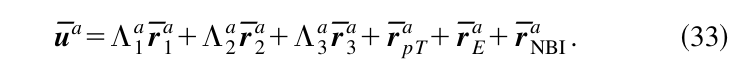

Then they go back to 27

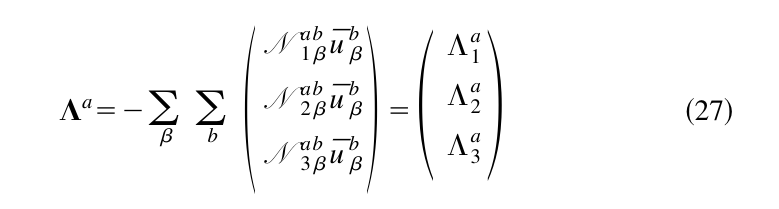

Essentially to back-substitute the $\Lambda^a_i$s, and they get "a linear set of 3n equations for three parallel flow components for the n isotopes",

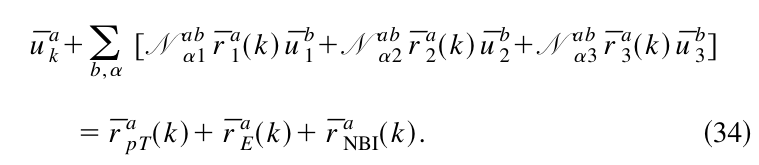

**This** is the equation that gets solved, and the one to tackle the ingredients of next.

In [24]:
from plasmapy.formulary.neoclassical import rbar

rbar(a, all_species)

<Quantity [[-1.08352471,  0.08779914,  0.28637432],
           [ 0.08779914,  0.14056926,  0.06473159],
           [ 0.28637432,  0.06473159, -0.15146658]] m3 s / kg>

In [25]:
rbar(all_species["C"], all_species)

<Quantity [[-0.147542  ,  0.01212044,  0.01659444],
           [ 0.01212044,  0.02561658,  0.01224642],
           [ 0.01659444,  0.01224642, -0.02044809]] m3 s / kg>

## The matrix equation solution; all the indices

Okay, this is something stupid. They use

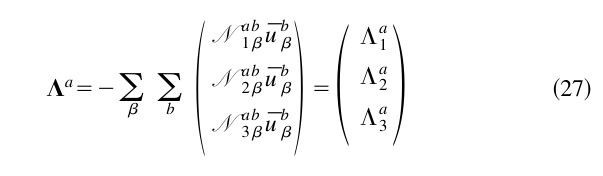

The inner parenthesis has 3 components. Its indices are $(\alpha = [1, 2, 3], \beta, a, b)$

This corresponds to a 4D ndarray.

I'm not yet sure why $\beta$ is there on different "rights" thatn $\alpha$. I guess its column vector status and 

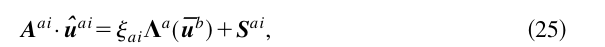

signifies that it's supposed to be a column-row product?

Anyway, let's think about this. We take $N_{\alpha,\beta}^{ab} \bar{u}_\beta^b$. Purely index notation for now and we'll worry about the minus sign later. This is a 4d matrix where, along axes 2 and 4, $\bar{u}$ is applied. Okay.

Summing along $\beta, b$, we reduce this from a 4D (3, 3, N, N) matrix to a 2D (3, N) matrix. Cool. So this does have 3 rows, as shown in eq 27 above.

Thus, $\mathbf{\Lambda}^a$.shape $= (3, N) \implies \mathbf{\Lambda}^a = \Lambda_\gamma^a$.

Note that given we don't yet know $\bar{u}_\beta^b$, we cannot actually compute this just yet. That's what we're going to solve for.

Onwards.

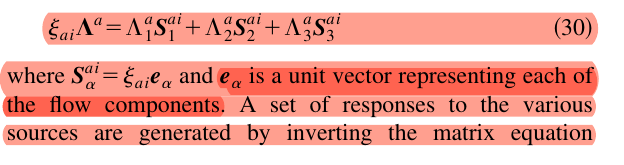

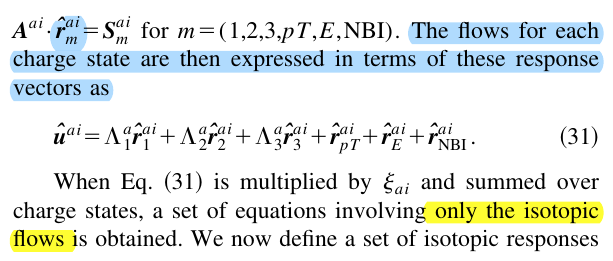

Take the "matrix equation" now. $\mathbf{A}^{ai}$ was defined earlier as

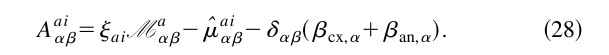

and

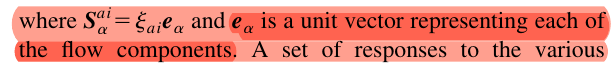

So the matrix equation

$$\mathbf{A}^{ai} \cdot \hat{r}_m^{ai} = \mathbf{S}_m^{ai}$$

is in fact a, for each charge state $ai$, a $(3, 3) \cdot (3,) = (3,)$ matrix equation.

Given that $m = (1, 2, 3, pT, E, NBI), [m] = 6$, that could be recast into a $(3, 3) \cdot (3, 6) = (3, 6)$ matrix equation. In theory. Is that correct?

In [26]:
Amatrix = np.random.random((3, 3))
Smatrix = np.random.random((3, 6))
np.linalg.solve(Amatrix, Smatrix).shape

(3, 6)

Yup! But that would require us to write $r_{\gamma,m}^{ai}$ and $S_{\gamma, m}^{ai}$. Where I chose $\gamma$ to not collide with any existing moment order indices. Awesome.

Then equation 31 can be recast into a matrix product if we were to take a helper matrix $I_6$ (6-dim or m-dim identity) where the upper half is multiplied by $\mathbf{\Lambda}^a$... TODO

But let's skip that for now and carry on. Let's rewrite 32...

$$\bar{r}_{\gamma, m}^a \equiv \Sigma_i \xi_{ai} \hat{r}_{\gamma, m}^{ai}$$

Still a (3, 6) array; and the superscript seems to imply it's going to be a (3, 6, N) array, where N is the number of isotopes in the system. This is a weird non-line

sparse

holy shit, this is a use case for sparse matrices

because the number of charge states varies between different isotopes, right? Hydrogen has basically one, two when accounting for neutrals. Tungsten, though...

[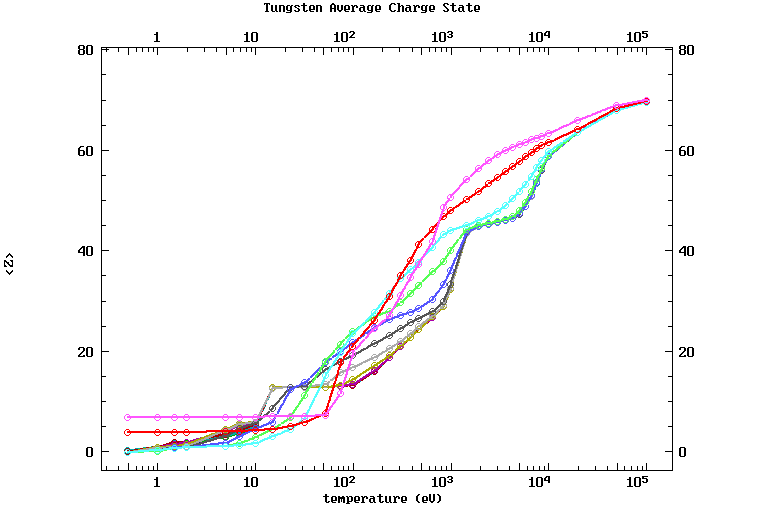](https://www-nds.iaea.org/exfor/servlet/X4sZvd?file=https://www-amdis.iaea.org/FLYCHK/ZBAR/zp074.zvd)

Tungsten goes to like 80 or so. Okay. So we could imagine taking max(number of charge states in the system) = M and allocating this huge array of shape (3, 6, N, M). Well, that's a boatload of zeros, right? Sure. But if this were to be a sparse array, well... that solves both the memory problem of allocating a boatload of zeros, and the speed problem by just not taking the zeros into account.

Huh.

Huuuuuuh.

Something to think about. Still, (32) sidesteps this by essentially collapsing our sparse (3, 6, N, M) array into a dense (3, 6, N) array.

(33) does exactly the thing I thought of above in 31. The shape on this thing is (3, 6, N), still. Right? I mean it has to be, no? 3 moment orders, 6 sources of flow, N isotopes. Yeah, that sounds about right. And the trick with the block `[[Lambda * eye(3)], 0], [0, eye(3)]]` array still should apply. Okayo.

Well, now they combine (27) with (33). This means, in our (3, 6, N) matrix equation, TODO

I honestly think I need to disregard their way of writing (34) and write it myself, with my own notation, from scratch. Let's do that, tbh.

$$\bar{u}_k^a = \Lambda_1^a \bar{r}_{k, 1}^a + \Lambda_2^a \bar{r}_{k, 2}^a + \Lambda_3^a \bar{r}_{k, 3}^a + \bar{r}_{k,pT}^a + \bar{r}_{k,E}^a + \bar{r}_{k, NBI}^a$$

$$\bar{u}_k^a = \Lambda_\alpha^a \bar{r}_{k, \alpha}^a + \bar{r}_{k,pT}^a + \bar{r}_{k,E}^a + \bar{r}_{k, NBI}^a$$

$$\bar{u}_k^a = -N^{ab}_{\alpha\beta} \bar{u}^b_\beta \bar{r}_{k, \alpha}^a + \bar{r}_{k,pT}^a + \bar{r}_{k,E}^a + \bar{r}_{k, NBI}^a$$

| Quantity               | Shape   | Notes                                  |
|------------------------|---------|----------------------------------------|
| $\bar{u}_\gamma^a$     | 3, N    |we solve for this!                      |
| $\bar{r}_{\gamma,m}^a$ | 3, 6, N |all responses, +rhs                     |
| $\Lambda_\gamma^a$     | 3, N    |$-N^{ab}_{\gamma \beta} \bar{u}_\beta^b$; contraction of (3, 3, N, N) with (1, 3, 1, N)|

Now we use (with the summation convention)

$$\Lambda^a_\gamma = -N^{ab}_{\gamma \beta} \bar{u}_\beta^b$$

Subsitute:

$$\bar{u}_\gamma^a = -\sum_{m=(1,2,3)} N_{\gamma\beta}^{ab}\bar{u}_\beta^b \bar{r}_{\gamma, m}^a + \sum_{m=(pT, E, \text{NBI})} \bar{r}_{\gamma, m}^a$$

$$\bar{u}_\gamma^a = - \sum_{b,\beta} N_{\gamma\beta}^{ab}\bar{u}_\beta^b \bar{r}_{\gamma, \beta}^a + \sum_{m=(pT, E, \text{NBI})} \bar{r}_{\gamma, m}^a$$

$$\bar{u}_\gamma^a +\sum_{b,\beta}N_{\gamma\beta}^{ab} \bar{r}_{\gamma, \beta}^a \bar{u}_\beta^b = \sum_{m=(pT, E, \text{NBI})} \bar{r}_{\gamma, m}^a$$

$$(3, N) + (3, 3, N, N) \otimes (3, 3, N) = (3, N)$$

In [27]:
lista = [[(a, b) for b in all_species] for a in all_species]

[[(<IonizationState instance for H>, <IonizationState instance for H>),
  (<IonizationState instance for H>, <IonizationState instance for C>)],
 [(<IonizationState instance for C>, <IonizationState instance for H>),
  (<IonizationState instance for C>, <IonizationState instance for C>)]]

In [28]:
len_all_species = 2  # TODO

2

In [30]:
from plasmapy.formulary.neoclassical import eq34matrix

In [31]:
output_matrix = eq34matrix(all_species)

TypeError: object of type 'IonizationStateCollection' has no len()

In [32]:
plt.imshow(output_matrix)
plt.colorbar()

NameError: name 'output_matrix' is not defined

And then they get the flows for each charge state using

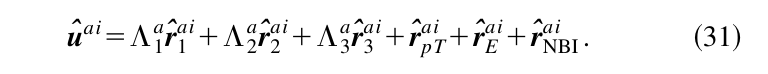

## Particle (and heat) fluxes

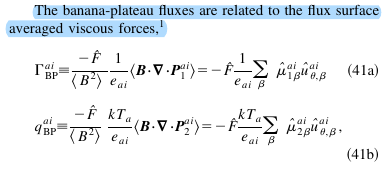

Note how they use here the $\hat{\mu}$ coefficients and the reconstructed flow velocities $\hat{\mu}^{ai}$. To get the poloidal flow velocities, they use eq. 19 and the ones following:

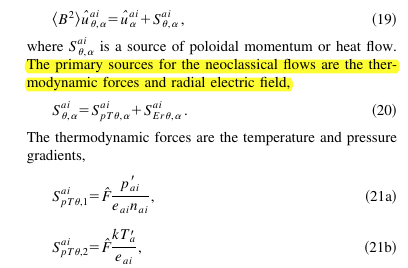

Meanwhile,

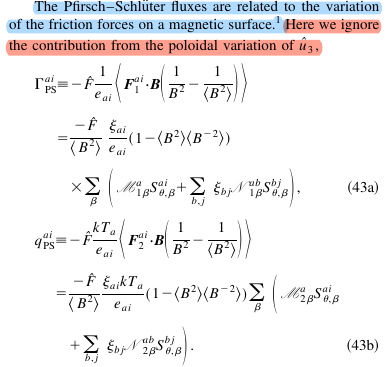

Note how this absolutely does not depend on the velocities. I could in fact probably start coding it up now, except for the $S_{\theta,\beta}^{ai}$ term, which is... the poloidal momentum/heat flow source from eq. 19 and following. Coolio.

Meanwhile, for the classical terms:

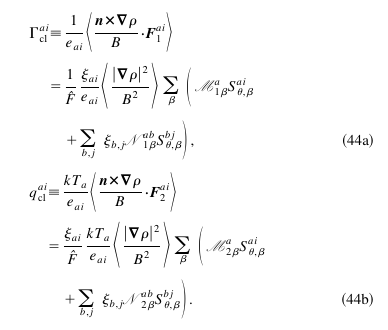

Mostly dependence on the script matrices, once again the poloidal source

In [ ]:
ai = a[1]
# Houlberg_1997, eq. 41a
def beta_sum():
    for i in range(3):
        yield i
        # yield mu^hat_1_beta^ai * u^hat_theta,beta^ai


Flux_BP_ai = -fs.Fhat / ai.ion.charge * sum(beta_sum())

# Appendix A

In [ ]:
from plasmapy.formulary.neoclassical import L_friction_coefficient

In [ ]:
L_friction_coefficient(a, 1, a, 1, all_species)  # TODO refactor

# Appendix B

## Trapped fraction

In [ ]:
fs.plot(n=True, B=True);

In [ ]:
trapped_fractions = {}
for psi_value, fs in surfaces.items():
    trapped_fractions[psi_value] = {
        "f_tl": fs._f_tl,
        "f_tu": fs._f_tu,
        "f_t": fs.trapped_fraction(),
    }
import pandas as pd

df = pd.DataFrame(trapped_fractions).T

In [ ]:
df.plot()

In [ ]:
h = fs.Bmag / fs.Bmax
plt.plot(fs.lp, h)

In [ ]:
plt.plot(fs.lp, fs.Bp)
plt.plot(fs.lp, fs.Bphivals)

In [ ]:
hmean = fs.flux_surface_average(h)

In [ ]:
h2mean = fs.flux_surface_average(h ** 2)

In [ ]:
plt.plot(fs.lp, h),
plt.plot(fs.lp, h ** 2)
plt.plot(fs.lp, 1 - h)
plt.plot(fs.lp, 1 + h / 2)
plt.plot(fs.lp, h ** -2)
plt.plot(fs.lp, (1 - (1 - h) ** 0.5 * (1 + h / 2)))
plt.plot(fs.lp, (1 - (1 - h) ** 0.5 * (1 + h / 2)) / h ** 2)

In [ ]:
f_tu = 1 - h2mean / hmean ** 2 * (1 - (1 - hmean) ** 0.5 * (1 + hmean / 2))
f_tl = 1 - h2mean * fs.flux_surface_average(
    h ** -2 * (1 - (1 - h) ** 0.5) * (1 + h / 2)
)
f_tu, f_tl, (f_tu - f_tl) / f_tl

In [ ]:
if not (f_tu - f_tl) / f_tl < 0.1:
    print(f_tu, f_tl, (f_tu - f_tl) / f_tl)

## Pfirsch-Schlueter contribution

In [ ]:
Theta = fs.Theta
B20 = fs.Brvals * fs.Bprimervals + fs.Bzvals * fs.Bprimezvals
plt.plot(fs.lp, B20)

# B17
Bprimevectors = np.stack((fs.Bprimervals, fs.Bprimezvals))

under_average_B17 = np.array(
    [np.dot(ni, Bpi) ** 2 for (ni, Bpi) in zip(fs.n.T, Bprimevectors.T)]
)
plt.plot(fs.lp, under_average_B17)
B2mean = fs.flux_surface_average(fs.B2)
B17 = fs.flux_surface_average(under_average_B17) / B2mean

### F_m and its unknown values

In [ ]:
num_m = 1000


def F_m(m, g=1):
    if g == 0:
        return np.nan
    under_average_B16 = np.sin(m * Theta) * B20
    under_average_B15 = under_average_B16 / fs.Bmag
    under_average_B16_cos = np.cos(m * Theta) * B20
    under_average_B15_cos = under_average_B16_cos / fs.Bmag
    #     plt.plot(fs.lp, under_average_B15)
    #     plt.plot(fs.lp, under_average_B16)
    B15 = fs.flux_surface_average(under_average_B15)
    B16 = fs.gamma * fs.flux_surface_average(under_average_B16)
    B15_cos = fs.flux_surface_average(under_average_B15_cos)
    B16_cos = fs.gamma * fs.flux_surface_average(under_average_B16_cos)

    jacobian = g ** 0.5
    BdotNablatheta = 1 / (2 * np.pi) / jacobian  # NotImplemented # see right after B14
    F_m = B9 = 2 / B2mean / BdotNablatheta * (B15 * B16 + B15_cos * B16_cos)
    return F_m


def optimizer(g):
    mrange = range(1, num_m)
    F_ms = np.array([F_m(m, g) for m in mrange])
    diff = F_ms.sum() - B17
    return diff ** 2


from scipy import optimize

optimization = optimize.minimize_scalar(optimizer)
mrange = range(1, 2 * num_m)
F_ms = np.array([F_m(m, optimization.x) for m in mrange])
plt.plot(F_ms, "o--", label=fr"$F_m(g={optimization.x:e})$")
plt.plot(np.array([F_m(m, 1) for m in mrange]), "o--", label=r"$F_m(g=1)$")
plt.xticks(mrange)
plt.legend()

In [ ]:
cumsum = np.cumsum(F_ms)

In [ ]:
cumsum - B17

In [ ]:
plt.plot(cumsum - B17, "bo--", label=r"$\sum_m F_m -$ B17")
# plt.axhline(0, color="black"
#            )
plt.yscale("log")
plt.xticks(mrange)
plt.legend()

So this probably sucks as a solution, a little.

In [ ]:
from plasmapy.formulary import thermal_speed

In [ ]:
a.T_e

In [ ]:
from astropy import constants

In [ ]:
thermal_speed(a.T_e, a._particle)

In [ ]:
from __future__ import annotations


def ωm(x, m, a: isotopelike, fs):
    B11 = (
        x * thermal_speed(a.T_e, a._particle) * m * fs.gamma / u.m
    )  # TODO why the u.m?
    # TODO not sure about the m * gamma part...
    return B11

In [ ]:
all_species

In [ ]:
from plasmapy.formulary.mathematics import Chandrasekhar_G
from plasmapy.formulary.neoclassical import xab_ratio

In [ ]:
b = all_species["C"]

In [ ]:
Chandrasekhar_G(1 / xab_ratio(a, b))

In [ ]:
X = 1

In [ ]:
from scipy.special import erf

In [ ]:
from plasmapy.formulary.neoclassical import effective_momentum_relaxation_rate

In [ ]:
def ν_T_ai(ai, a, all_species):
    prefactor = 3 * np.pi ** 0.5 / 4 * ξ(a)[i] / ai.number_density / ai.ion.mass

    def gen():
        for b in all_species:
            if b.base_particle != a.base_particle:  # TODO is not should work
                x_over_xab = X / xab_ratio(a, b).si.value
                print(b)
                part1 = erf(x_over_xab) - 3 * Chandrasekhar_G(x_over_xab) / X ** 3
                part2 = 4 * (
                    a.T_e / b.T_e + xab_ratio(a, b) ** -2
                )  # TODO adjust ratios
                part2full = part2 * Chandrasekhar_G(x_over_xab) / X
                yield (part1 + part2full) * effective_momentum_relaxation_rate(a, b)

    result = prefactor * sum(gen())
    return result

In [ ]:
def K_ps_ai(x, ai, a, all_species, m_max=100):
    ν = ν_T_ai(ai, a, all_species)

    def gen():
        for m in range(1, m_max):
            F = F_m(m, g=optimization.x)  # TODO replace
            ω = ωm(x, m, a, fs)
            B10 = (
                1.5 * (ν / ω) ** 2
                - 9 / 2 * (ν / ω) ** 4
                + (1 / 4 + (3 / 2 + 9 / 4 * (ν / ω) ** 2) * (ν / ω) ** 2)
                * (2 * ν / ω)
                * np.arctan(ω / ν).si.value
            )
            yield F * B10 / ν

    return 3 / 2 * thermal_speed(a.T_e, a.base_particle) ** 2 * x ** 2 * sum(gen())


K_ps_ai(1, ai, a, all_species)

In [ ]:
from plasmapy.formulary.neoclassical import K_B_ai

In [ ]:
K_B_ai(1, 1, a, all_species, fs)

$$[K_B^{ai}] = \frac{1}{1} \frac{[\nu_{D,ai}]}{1}$$

$$[\nu_{D,ai}] = s^{-1}$$

In [ ]:
ν_T_ai(ai, a, all_species)

In [ ]:
m = 1
F = F_m(m, g=optimization.x)  # TODO replace
ω = ωm(X, m, a, fs)
B10 = (
    1.5 * (ν / ω) ** 2
    - 9 / 2 * (ν / ω) ** 4
    + (1 / 4 + (3 / 2 + 9 / 4 * (ν / ω) ** 2) * (ν / ω) ** 2)
    * (2 * ν / ω)
    * np.arctan(ω / ν).si.value
)
sum_ingredient = F * B10 / ν
result = 3 / 2 * thermal_speed(a.T_e, a.base_particle) ** 2 * X ** 2 * sum_ingredient

In [ ]:
B10